In [ ]:
import re
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# --------------------------
# Step 1: Preprocessing
# --------------------------
def preprocess(text):
    """Lowercase, tokenize, remove stopwords."""
    text = text.lower()
    tokens = re.findall(r"\b[a-z]+\b", text)
    stopwords = set([
        "the","is","in","and","to","of","a","on","for","with","that","as","at","by","an","it","this","from","be","are",
        "will","now","have","has","been","which","these","their","they","its","but","or","such","into","were","also",
        "than","other","up","per","over",'not','no','s'
    ])
    return [w for w in tokens if w not in stopwords]

# --------------------------
# Step 2: Build TF Matrix
# --------------------------
def build_tf_matrix(paragraphs):
    processed = [preprocess(p) for p in paragraphs]
    vocab = sorted(set(word for para in processed for word in para))
    vocab_index = {w:i for i,w in enumerate(vocab)}

    tf = np.zeros((len(vocab), len(paragraphs)), dtype=int)
    for j, para in enumerate(processed):
        counts = Counter(para)
        for word,count in counts.items():
            tf[vocab_index[word], j] = count

    return tf, vocab

# --------------------------
# Step 3: Compute Similarities
# --------------------------
def compute_similarities(tf_matrix):
    para_vecs = tf_matrix.T
    cosine_sim = cosine_similarity(para_vecs)
    dot_sim = para_vecs @ para_vecs.T
    return cosine_sim, dot_sim

# --------------------------
# Step 4: Analyze Results
# --------------------------
def find_extremes(sim_matrix):
    n = sim_matrix.shape[0]
    max_val, min_val = -1, float("inf")
    max_pair, min_pair = None, None
    for i in range(n):
        for j in range(i+1, n):
            val = sim_matrix[i,j]
            if val > max_val:
                max_val, max_pair = val, (i,j)
            if val < min_val:
                min_val, min_pair = val, (i,j)
    return max_pair, max_val, min_pair, min_val

# --------------------------
# Step 5: Influential Terms
# --------------------------

def top_terms_between(tf_matrix, vocab, p1, p2, top_k=5):
    # Make sure paragraph indices are valid
    n_paras = tf_matrix.shape[1]
    n_words = tf_matrix.shape[0]
    if p1 >= n_paras or p2 >= n_paras:
        raise IndexError(f"Paragraph indices out of range: p1={p1}, p2={p2}, n_paras={n_paras}")

    v1, v2 = tf_matrix[:, p1], tf_matrix[:, p2]
    overlap = v1 * v2
    diff = np.abs(v1 - v2)

    # Safe overlap
    overlap_idx = np.argsort(-overlap)
    top_overlap = []
    for i in overlap_idx:
        if i >= len(vocab):
            continue  # skip invalid indices
        if overlap[i] > 0:
            top_overlap.append((vocab[i], int(overlap[i]), int(v1[i]), int(v2[i])))
        if len(top_overlap) >= top_k:
            break

    # Safe difference
    diff_idx = np.argsort(-diff)
    top_diff = []
    for i in diff_idx:
        if i >= len(vocab):
            continue
        if diff[i] > 0:
            top_diff.append((vocab[i], int(diff[i]), int(v1[i]), int(v2[i])))
        if len(top_diff) >= top_k:
            break

    # Debug prints
    print(f"top_overlap for P{p1}-P{p2}: {top_overlap}")
    print(f"top_diff for P{p1}-P{p2}: {top_diff}")

    return top_overlap, top_diff


In [ ]:
#SUPPORT FUNCTIONS

def rank_pairs(sim_matrix, method="cosine"):
    n = sim_matrix.shape[0]
    results = []
    for i in range(n):
        for j in range(i+1, n):
            results.append((f"P{i}-P{j}", sim_matrix[i,j]))
    results.sort(key=lambda x: x[1], reverse=True)
    print(f"\n=== All paragraph pairs ranked by {method} similarity ===")
    for pair, score in results:
        print(f"{pair}: {score:.4f}")
    return results

def plot_top_pairs(ranked, method="cosine", top_n=5):
    # take top N
    pairs = [p for p, _ in ranked[:top_n]]
    scores = [s for _, s in ranked[:top_n]]

    plt.figure(figsize=(8, 4))
    bars = plt.barh(pairs[::-1], scores[::-1], color="skyblue", edgecolor="black")

    # Add score labels to bars
    for bar, score in zip(bars, scores[::-1]):
        plt.text(bar.get_width() + 0.01,
                 bar.get_y() + bar.get_height()/2,
                 f"{score:.3f}", va="center", fontsize=10)

    plt.xlabel("Similarity Score", fontsize=12)
    plt.ylabel("Paragraph Pairs", fontsize=12)
    plt.title(f"Bottom {top_n} Paragraph Pairs calculated by {method.title()} Similarity", fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_bottom_pairs(ranked, method="cosine", bottom_n=5):
    bottom_pairs = [p for p, _ in ranked[-bottom_n:]]
    bottom_scores = [s for _, s in ranked[-bottom_n:]]

    plt.figure(figsize=(8, 4))
    bars = plt.barh(bottom_pairs[::-1], bottom_scores[::-1], color="indianred", edgecolor="black")
    for bar, score in zip(bars, bottom_scores[::-1]):
        plt.text(bar.get_width() + 0.01,
                 bar.get_y() + bar.get_height()/2,
                 f"{score:.3f}", va="center", fontsize=10)
    plt.xlabel("Similarity Score", fontsize=12)
    plt.ylabel("Paragraph Pairs", fontsize=12)
    plt.title(f"Bottom {bottom_n} Paragraph Pairs calculated by {method.title()} Similarity", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_top_terms(tf_matrix, vocab, p1, p2, top_k=5, method='health'):

    top_overlap, top_diff = top_terms_between(tf_matrix, vocab, p1, p2, top_k)

    # --- Helper function for plotting bars ---
    def plot_bar(data_list, title, colors=('seagreen','indianred')):
        if not data_list:
            print(f"No terms to plot for: {title}")
            return

        # Filter indices to prevent out-of-range errors
        filtered = [(term, count, v1, v2)
                    for term, count, v1, v2 in data_list
                    if term in vocab]
        if not filtered:
            print(f"No valid terms to plot for: {title}")
            return

        terms, counts, v1_counts, v2_counts = zip(*filtered)
        x = np.arange(len(terms))
        width = 0.35

        plt.figure(figsize=(8,4))
        plt.barh(x - width/2, v1_counts, height=width, label=f"Paragraph {p1}", color=colors[0])
        plt.barh(x + width/2, v2_counts, height=width, label=f"Paragraph {p2}", color=colors[1])
        plt.yticks(x, terms)
        plt.xlabel("Term Count")
        plt.title(title)
        plt.legend()
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    # --- Plot differing terms ---
    plot_bar(top_diff, f"Top {top_k} Differing Terms Between Paragraphs {p1} & {p2}")

    # --- Plot top contributing terms to similarity ---
    v1, v2 = tf_matrix[:, p1], tf_matrix[:, p2]
    if method == "cosine":
        norm = np.linalg.norm(v1) * np.linalg.norm(v2)
        contrib = (v1 * v2) / norm if norm != 0 else np.zeros_like(v1)
    elif method == "dot product":
        contrib = v1 * v2
    else:
        raise ValueError("method must be 'cosine' or 'dot'")

    top_idx = np.argsort(-contrib)[:top_k]
    top_contrib_terms = [(vocab[i], contrib[i], v1[i], v2[i]) for i in top_idx if contrib[i] > 0]

    plot_bar(top_contrib_terms, f"Top {top_k} Terms Contributing to {method.title()} Similarity")


In [ ]:
# --------------------------
# Main Driver
# --------------------------
# 1. Load file
filename = "pract1_data.txt"   # <-- change path if needed
with open(filename, "r", encoding="utf-8") as f:
    raw = f.read().strip()

# 2. Split into paragraphs (blank lines)
paragraphs = [p.strip() for p in re.split(r"\n\s*\n", raw) if p.strip()]
print(f"Loaded {len(paragraphs)} paragraphs\n")

# 3. Build TF matrix
tf_matrix, vocab = build_tf_matrix(paragraphs) # Move tf_matrix and vocab definition outside the if block
tf_df = pd.DataFrame(tf_matrix, index=vocab, columns=[f"P{i}" for i in range(len(paragraphs))])
tf_df.to_csv("tf_matrix.csv")
print("TF matrix saved to tf_matrix.csv")


if __name__ == "__main__":
    # 4. Compute similarities
    cos_sim, dot_sim = compute_similarities(tf_matrix)
    cos_df = pd.DataFrame(cos_sim, index=[f"P{i}" for i in range(len(paragraphs))],
                          columns=[f"P{i}" for i in range(len(paragraphs))])
    dot_df = pd.DataFrame(dot_sim, index=[f"P{i}" for i in range(len(paragraphs))],
                          columns=[f"P{i}" for i in range(len(paragraphs))])
    cos_df.to_csv("cosine_similarity_matrix.csv")
    dot_df.to_csv("dot_product_similarity_matrix.csv")
    print("Cosine and dot-product matrices saved.")

    # 5. Analyze results
    cos_max, cos_max_val, cos_min, cos_min_val = find_extremes(cos_sim)
    dot_max, dot_max_val, dot_min, dot_min_val = find_extremes(dot_sim)

    def label(pair): return f"P{pair[0]}-P{pair[1]}"

    print("\n=== Cosine Similarity ===")
    print("Most similar:", label(cos_max), "score:", cos_max_val)
    print("Least similar:", label(cos_min), "score:", cos_min_val)

    print("\n=== Dot Product Similarity ===")
    print("Most similar:", label(dot_max), "score:", dot_max_val)
    print("Least similar:", label(dot_min), "score:", dot_min_val)

    # 6. Influential terms
    print("\n--- Influential terms for Cosine most similar ---")
    sim_terms, diff_terms = top_terms_between(tf_matrix, vocab, cos_max[0], cos_max[1])
    print("Top overlapping:", sim_terms)
    print("Top differing:", diff_terms)

    print("\n--- Influential terms for Cosine least similar ---")
    sim_terms, diff_terms = top_terms_between(tf_matrix, vocab, cos_min[0], cos_min[1])
    print("Top overlapping:", sim_terms if sim_terms else "(none)")
    print("Top differing:", diff_terms)

    print("\n--- Influential terms for Dot most similar ---")
    sim_terms, diff_terms = top_terms_between(tf_matrix, vocab, dot_max[0], dot_max[1])
    print("Top overlapping:", sim_terms)
    print("Top differing:", diff_terms)

    print("\n--- Influential terms for Dot least similar ---")
    sim_terms, diff_terms = top_terms_between(tf_matrix, vocab, dot_min[0], dot_min[1])
    print("Top overlapping:", sim_terms if sim_terms else "(none)")
    print("Top differing:", diff_terms)

Loaded 14 paragraphs

TF matrix saved to tf_matrix.csv
Cosine and dot-product matrices saved.

=== Cosine Similarity ===
Most similar: P0-P13 score: 0.4225640725710898
Least similar: P4-P8 score: 0.0

=== Dot Product Similarity ===
Most similar: P0-P13 score: 34
Least similar: P4-P8 score: 0

--- Influential terms for Cosine most similar ---
top_overlap for P0-P13: [('new', 12, 4, 3), ('reforms', 6, 2, 3), ('gst', 4, 2, 2), ('sikkim', 4, 2, 2), ('tax', 2, 2, 1)]
top_diff for P0-P13: [('tourism', 2, 2, 0), ('women', 1, 0, 1), ('witnessed', 1, 0, 1), ('align', 1, 1, 0), ('affordable', 1, 0, 1)]
Top overlapping: [('new', 12, 4, 3), ('reforms', 6, 2, 3), ('gst', 4, 2, 2), ('sikkim', 4, 2, 2), ('tax', 2, 2, 1)]
Top differing: [('tourism', 2, 2, 0), ('women', 1, 0, 1), ('witnessed', 1, 0, 1), ('align', 1, 1, 0), ('affordable', 1, 0, 1)]

--- Influential terms for Cosine least similar ---
top_overlap for P4-P8: []
top_diff for P4-P8: [('tax', 2, 0, 2), ('sikkim', 2, 2, 0), ('pharmaceutical', 

In [ ]:
# most similars

print("Most Similar Paragraphs (Cosine Similarity, Value = 0.423) and (Dot Product Similarity, Value = 34)")
print()
print("Paragraph 1 -> ", paragraphs[0])
print()
print("Paragraph 14 ->", paragraphs[13])

print()
print("Comments:")
print('Paragraph 1 subtopic:  INTRODUCTION')
print('Paragraph 14 subtopic: CONCLUSION')

Most Similar Paragraphs (Cosine Similarity, Value = 0.423) and (Dot Product Similarity, Value = 34)

Paragraph 1 ->  The new GST reforms mark a major step toward lowering the tax burden on essential goods and
 services. These new rates will stimulate demand, boost competitiveness, and create new opportunities
 for growth and employment in the country. For Sikkim, a small Himalayan state with stakes in
 pharmaceuticals, tourism, and organic food products, the new GST reforms could not have come at a
 better time. The tax cuts align with Sikkim’s broader development goals, from industrial
 diversification to tourism promotion and uplifting rural livelihoods.

Paragraph 14 -> By easing the tax burden on Sikkim’s key economic sectors, the new GST reforms will act as a
 catalyst for holistic development of the state’s economy. As these reforms take hold, their effects can be witnessed through a pharma plant dispatching an
 extra batch of medicines, a line of happy tourists extending their s

In [ ]:
print("One among 5 of the Least Similar Paragraphs (Cosine Similarity, Value = 0.0) and (Dot Product Similarity, Value = 0)")
print()
print("Paragraph 8 -> ", paragraphs[7])
print()
print("Paragraph 12 ->", paragraphs[11])


print()
print('Comments:')
print('Paragraph 5 subtopic: PHARMA & MEDICINE SECTOR')
print('Paragraph 9 subtopic: FOOD PROCESSING SECTOR')

One among 5 of the Least Similar Paragraphs (Cosine Similarity, Value = 0.0) and (Dot Product Similarity, Value = 0)

Paragraph 8 ->  Sikkim’s Temi estate’s tea is widely sought after in international markets such as USA, Germany, UK
 and Japan. The estate is modest in size with around 450 workers and small producers, but its
 impact is significant in terms of brand value and rural livelihood in Namchi district.

Paragraph 12 -> The recent GST reforms significantly improve cost competitiveness by reducing the tax rate on
 key items. Pickles, fruit and vegetable juices now attract just 5% GST instead of 12%, while products
 such as pastries, cakes, soups, and broths have seen reductions from 18% to 5%. These reforms
 directly lower shelf prices by 6-13%, stimulating higher consumer demand. This will further
 encourage higher fruit-to-factory procurement during peak seasons.

Comments:
Paragraph 5 subtopic: PHARMA & MEDICINE SECTOR
Paragraph 9 subtopic: FOOD PROCESSING SECTOR


In [ ]:
#no need to run #ACTUALLY - DON'T
cosine_ranked = rank_pairs(cos_sim, method="cosine")
dot_ranked = rank_pairs(dot_sim, method="dot product")


=== All paragraph pairs ranked by cosine similarity ===
P0-P13: 0.4226
P1-P13: 0.3112
P2-P3: 0.2734
P1-P11: 0.2572
P0-P1: 0.2568
P0-P2: 0.2549
P1-P3: 0.2421
P0-P3: 0.2357
P1-P2: 0.2347
P1-P6: 0.2293
P8-P11: 0.2274
P5-P8: 0.2256
P5-P11: 0.2254
P10-P12: 0.2206
P9-P13: 0.2137
P11-P13: 0.2091
P2-P5: 0.2057
P7-P9: 0.2040
P2-P8: 0.2018
P2-P11: 0.2007
P0-P11: 0.2003
P6-P13: 0.1924
P2-P13: 0.1874
P0-P9: 0.1837
P5-P13: 0.1818
P8-P9: 0.1807
P3-P13: 0.1758
P6-P9: 0.1750
P6-P7: 0.1695
P0-P8: 0.1682
P0-P6: 0.1679
P4-P6: 0.1669
P0-P5: 0.1626
P5-P9: 0.1612
P1-P9: 0.1533
P3-P11: 0.1525
P2-P9: 0.1511
P2-P4: 0.1509
P6-P8: 0.1502
P5-P6: 0.1489
P2-P6: 0.1465
P1-P5: 0.1461
P7-P13: 0.1380
P1-P4: 0.1336
P3-P6: 0.1296
P6-P11: 0.1284
P8-P13: 0.1223
P0-P4: 0.1201
P3-P8: 0.1189
P4-P13: 0.1164
P11-P12: 0.1132
P3-P4: 0.1132
P3-P12: 0.1110
P9-P11: 0.1104
P0-P12: 0.1099
P3-P5: 0.1061
P6-P10: 0.0953
P4-P7: 0.0953
P12-P13: 0.0913
P0-P7: 0.0813
P0-P10: 0.0801
P3-P9: 0.0779
P10-P13: 0.0776
P4-P12: 0.0735
P10-P11: 0.072

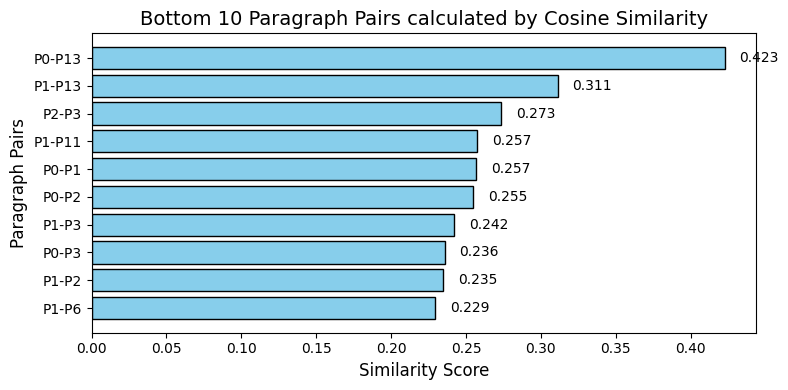

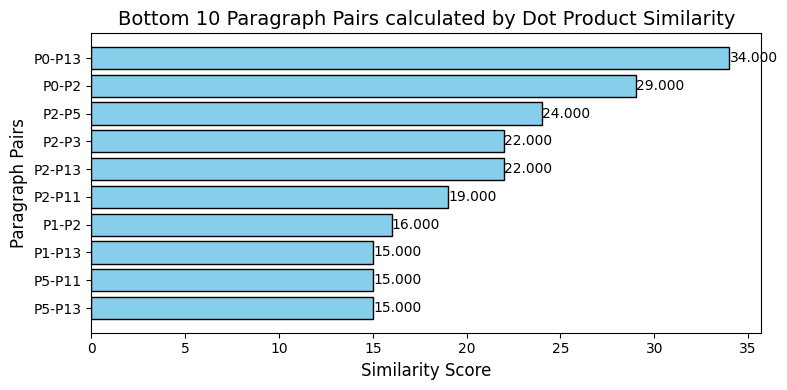

In [ ]:
# Example usage after ranking:
plot_top_pairs(cosine_ranked, method="cosine", top_n=10)
plot_top_pairs(dot_ranked, method="dot product", top_n=10)

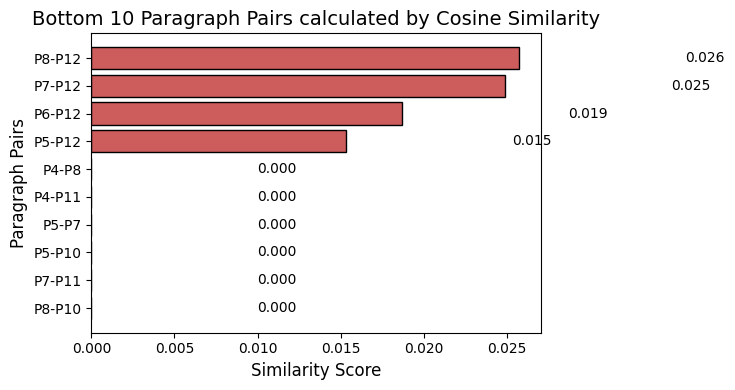

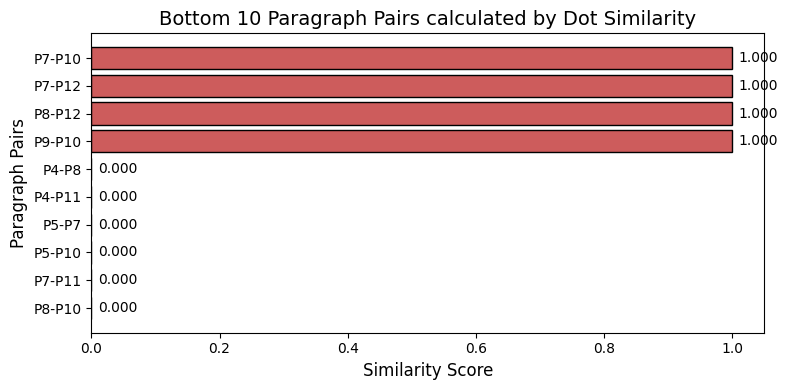

In [ ]:
plot_bottom_pairs(cosine_ranked, method='cosine', bottom_n=10)
plot_bottom_pairs(dot_ranked, method='dot', bottom_n=10)

top_overlap for P4-P8: []
top_diff for P4-P8: [('tax', 2, 0, 2), ('sikkim', 2, 2, 0), ('pharmaceutical', 2, 2, 0), ('gst', 2, 0, 2), ('translating', 1, 0, 1)]


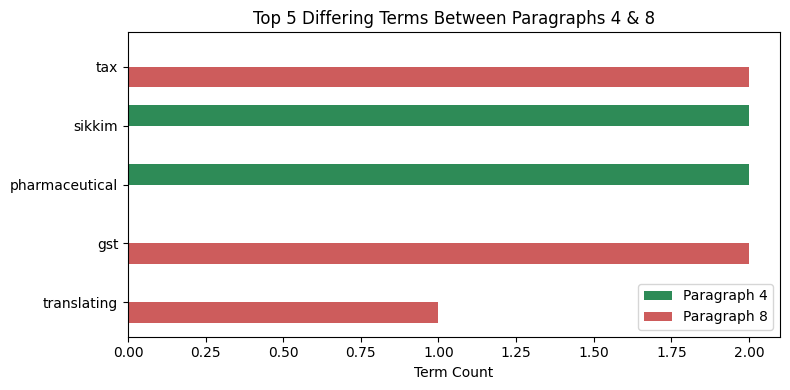

No terms to plot for: Top 5 Terms Contributing to Dot Product Similarity


In [ ]:
#both - common worst

p1_str, p2_str = cosine_ranked[-6][0].split('-')
p1, p2 = int(p1_str[1:]), int(p2_str[1:])
plot_top_terms(tf_matrix, vocab, p1, p2, top_k=5, method='dot product')

top_overlap for P0-P13: [('new', 12, 4, 3), ('reforms', 6, 2, 3), ('gst', 4, 2, 2), ('sikkim', 4, 2, 2), ('tax', 2, 2, 1)]
top_diff for P0-P13: [('tourism', 2, 2, 0), ('women', 1, 0, 1), ('witnessed', 1, 0, 1), ('align', 1, 1, 0), ('affordable', 1, 0, 1)]


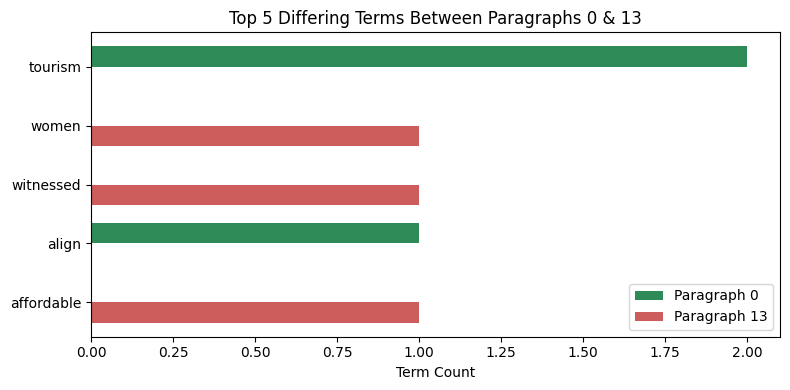

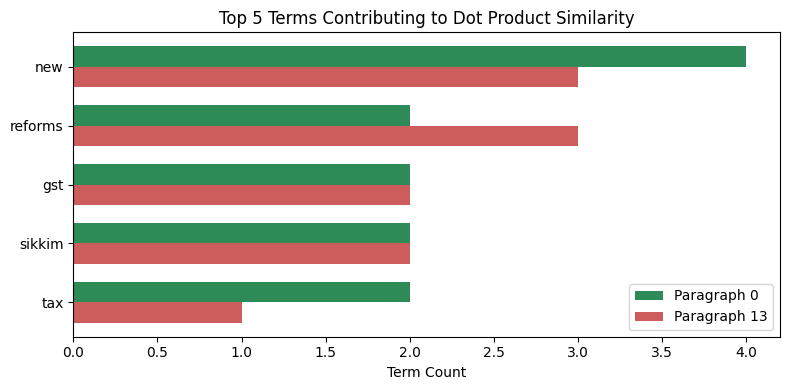

In [ ]:
#both - common best

p1_str, p2_str = cosine_ranked[0][0].split('-')
p1, p2 = int(p1_str[1:]), int(p2_str[1:])
plot_top_terms(tf_matrix, vocab, p1, p2, top_k=5, method='dot product')

top_overlap for P7-P11: []
top_diff for P7-P11: [('reforms', 2, 0, 2), ('estate', 2, 2, 0), ('fruit', 2, 0, 2), ('higher', 2, 0, 2), ('gst', 2, 0, 2)]


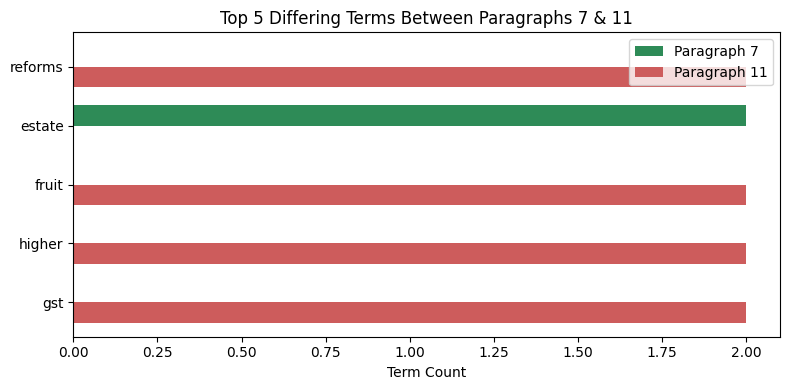

No terms to plot for: Top 5 Terms Contributing to Cosine Similarity


In [ ]:
#both - common worst

p1_str, p2_str = cosine_ranked[-2][0].split('-')
p1, p2 = int(p1_str[1:]), int(p2_str[1:])
plot_top_terms(tf_matrix, vocab, p1, p2, top_k=5, method='cosine')

top_overlap for P1-P13: [('sikkim', 4, 2, 2), ('reforms', 3, 1, 3), ('gst', 2, 1, 2), ('sectors', 1, 1, 1), ('more', 1, 1, 1)]
top_diff for P1-P13: [('new', 3, 0, 3), ('reforms', 2, 1, 3), ('women', 1, 0, 1), ('witnessed', 1, 0, 1), ('affordable', 1, 0, 1)]


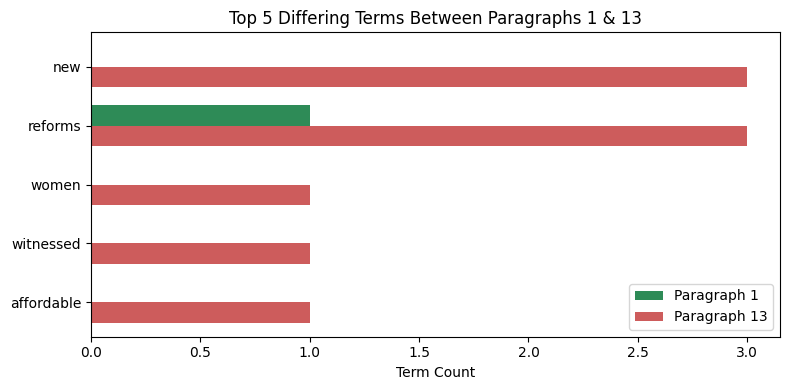

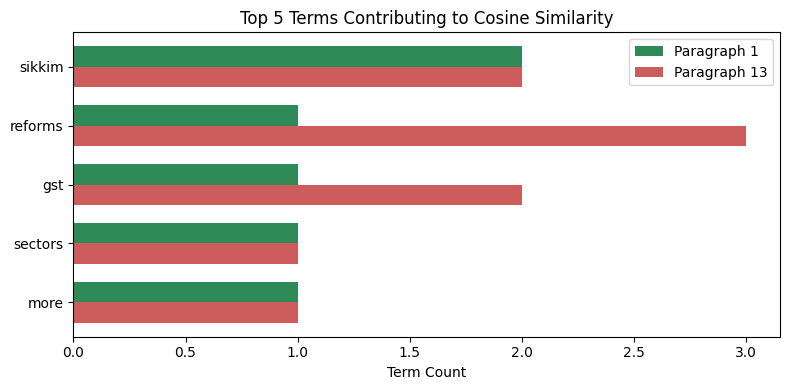

In [ ]:
# going for 2nd best: comparitive analysis:

# cosine (2nd best) 1-13
p1_str, p2_str = cosine_ranked[1][0].split('-')
p1, p2 = int(p1_str[1:]), int(p2_str[1:])
plot_top_terms(tf_matrix, vocab, p1, p2, top_k=5, method='cosine')

top_overlap for P0-P2: [('tourism', 8, 2, 4), ('gst', 8, 2, 4), ('sikkim', 4, 2, 2), ('tax', 4, 2, 2), ('services', 1, 1, 1)]
top_diff for P0-P2: [('new', 4, 4, 0), ('sector', 3, 0, 3), ('wellness', 3, 0, 3), ('reforms', 2, 2, 0), ('jobs', 2, 0, 2)]


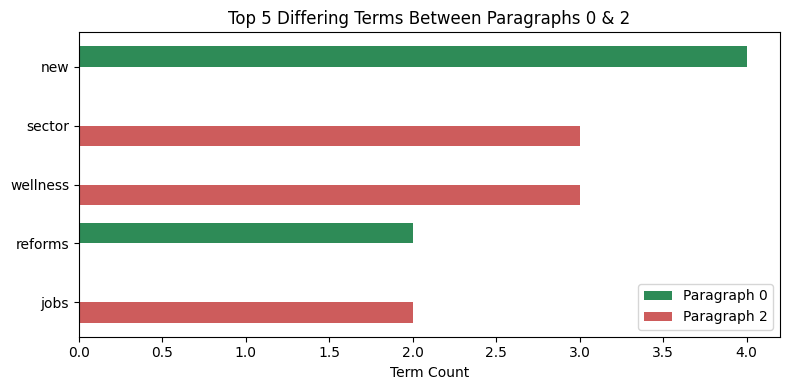

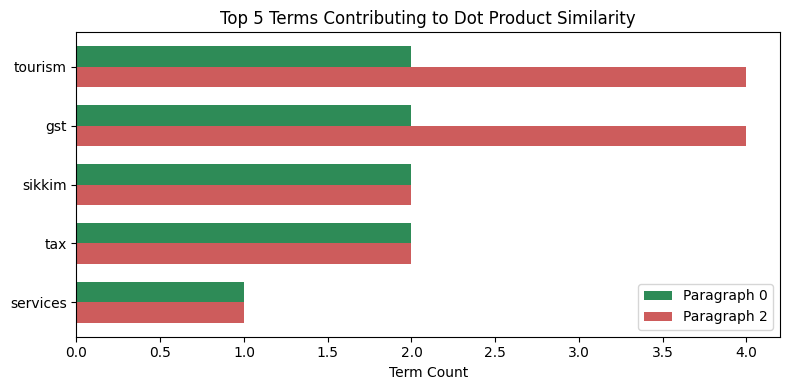

In [ ]:
# going for 2nd best: comparitive analysis:

# dot prod (2nd best) 0-2
p1_str, p2_str = dot_ranked[1][0].split('-')
p1, p2 = int(p1_str[1:]), int(p2_str[1:])
plot_top_terms(tf_matrix, vocab, p1, p2, top_k=5, method='dot product')

top_overlap for P5-P12: [('etc', 1, 1, 1)]
top_diff for P5-P12: [('gst', 4, 4, 0), ('medicines', 3, 3, 0), ('medical', 3, 3, 0), ('processing', 2, 0, 2), ('devices', 2, 2, 0)]


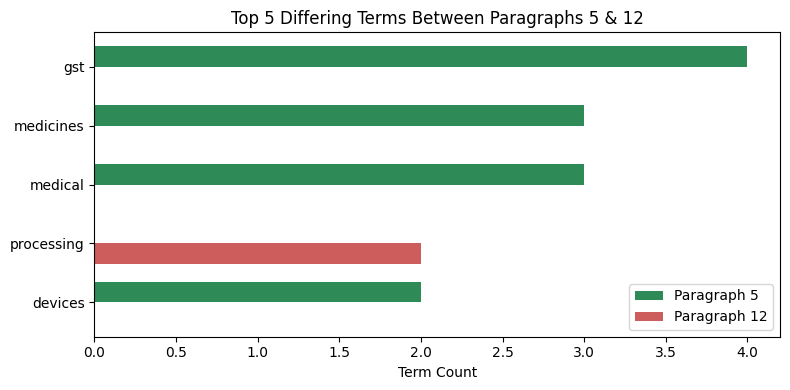

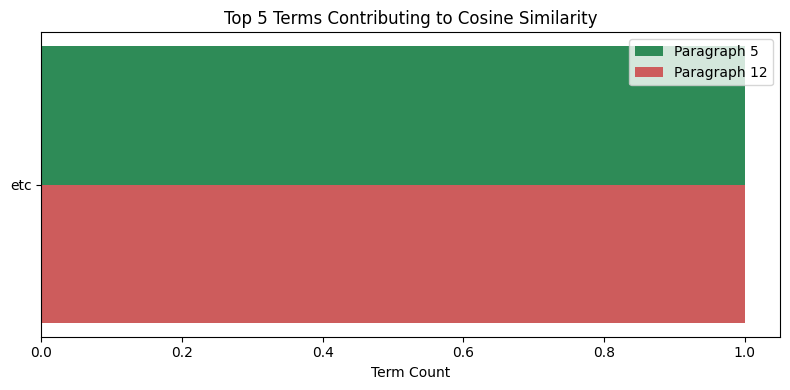

In [ ]:
# going for 2nd worst: comparitive analysis:

# cosine (2nd worst)
p1_str, p2_str = cosine_ranked[-7][0].split('-')
p1, p2 = int(p1_str[1:]), int(p2_str[1:])
plot_top_terms(tf_matrix, vocab, p1, p2, top_k=5, method='cosine')

top_overlap for P9-P10: [('sikkim', 1, 1, 1)]
top_diff for P9-P10: [('better', 2, 2, 0), ('tea', 2, 2, 0), ('gst', 2, 2, 0), ('based', 1, 0, 1), ('benefits', 1, 1, 0)]


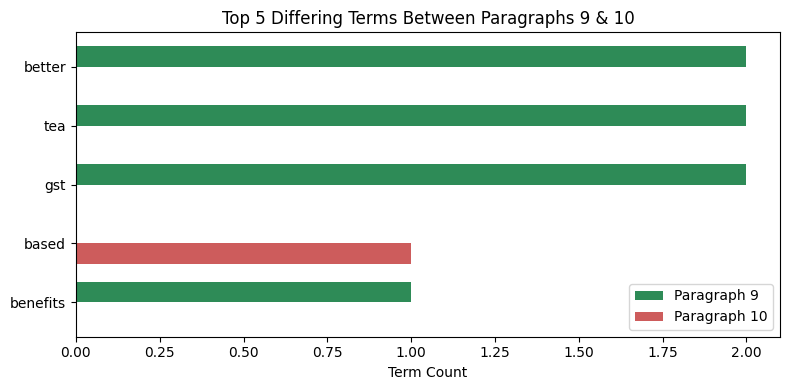

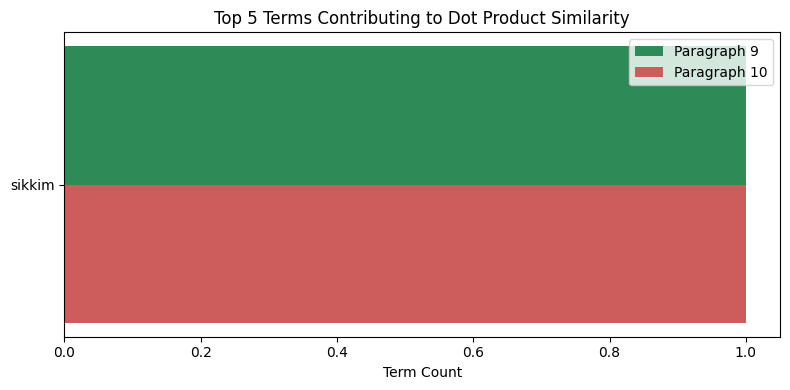

In [ ]:
# going for 2nd worst: comparitive analysis:

# dot (2nd worst)
p1_str, p2_str = dot_ranked[-7][0].split('-')
p1, p2 = int(p1_str[1:]), int(p2_str[1:])
plot_top_terms(tf_matrix, vocab, p1, p2, top_k=5, method='dot product')